In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import cv2
import numpy as np

import time
import sys
import os
import glob
import shutil

In [3]:
!mkdir predictions

In [4]:
dataset = 'hard'

In [5]:
CONFIDENCE = 0.0
SCORE_THRESHOLD = 0.5
IOU_THRESHOLD = 0.5

# the neural network configuration
config_path = "/content/drive/MyDrive/yolo/cfg/yolov3_dice.cfg"

# the YOLO net weights file
weights_path = "/content/drive/MyDrive/yolo/weights/yolov3_" + dataset + ".weights"
# weights_path = "weights/yolov3-tiny.weights"

# loading all the class labels (objects)
labels = open("/content/drive/MyDrive/yolo/data/dice.names").read().strip().split("\n")
# generating colors for each object for later plotting
colors = np.random.randint(0, 255, size=(len(labels), 3), dtype="uint8")

In [6]:
# load the YOLO network
net = cv2.dnn.readNetFromDarknet(config_path, weights_path)

In [7]:
zip = "/content/drive/MyDrive/yolo/dataset/test_" + dataset + ".zip"
!unzip $zip -d test

Archive:  /content/drive/MyDrive/yolo/dataset/test_hard.zip
  inflating: test/IMG_20211115_221858.jpg  
  inflating: test/9.jpg              
  inflating: test/IMG_20211122_211715.jpg  
  inflating: test/photo5219811615145310184.jpg  
  inflating: test/IMG_20211122_212235.jpg  
  inflating: test/IMG_20211122_211508.jpg  
  inflating: test/7.jpg              
  inflating: test/18.jpg             
  inflating: test/IMG_20211122_211944.jpg  
  inflating: test/IMG_20211122_211738.jpg  
  inflating: test/IMG_20211122_213903.jpg  
  inflating: test/IMG_20211122_211452.jpg  
  inflating: test/IMG_20211122_211919.jpg  
  inflating: test/photo5219811615145310169.jpg  
  inflating: test/photo5219811615145310198.jpg  
  inflating: test/IMG_20211122_211409.jpg  
  inflating: test/39.jpg             
  inflating: test/IMG_20211121_215826.jpg  
  inflating: test/IMG_20211121_215836.jpg  
  inflating: test/IMG_20211115_222238.jpg  
  inflating: test/14.jpg             
  inflating: test/IMG_20211115_

In [13]:
inference_time = []

def predict(path_name):
  image = cv2.imread(path_name)
  file_name = os.path.basename(path_name)
  filename, ext = file_name.split(".")

  h, w = image.shape[:2]
  # create 4D blob
  blob = cv2.dnn.blobFromImage(image, 1/255.0, (192, 192), swapRB=True, crop=False)

  # sets the blob as the input of the network
  net.setInput(blob)
  # get all the layer names
  ln = net.getLayerNames()
  ln = [ln[i[0] - 1] for i in net.getUnconnectedOutLayers()]
  # feed forward (inference) and get the network output
  # measure how much it took in seconds
  start = time.perf_counter()
  layer_outputs = net.forward(ln)
  time_took = time.perf_counter() - start
  print(f"Time took: {time_took:.2f}s")
  inference_time.append(time_took)

  font_scale = 0.3
  thickness = 1
  boxes, confidences, class_ids = [], [], []
  # loop over each of the layer outputs
  for output in layer_outputs:
      # loop over each of the object detections
      for detection in output:
          # extract the class id (label) and confidence (as a probability) of
          # the current object detection
          scores = detection[5:]
          class_id = np.argmax(scores)
          confidence = scores[class_id]
          # discard out weak predictions by ensuring the detected
          # probability is greater than the minimum probability
          if confidence > CONFIDENCE:
              # scale the bounding box coordinates back relative to the
              # size of the image, keeping in mind that YOLO actually
              # returns the center (x, y)-coordinates of the bounding
              # box followed by the boxes' width and height
              box = detection[:4] * np.array([w, h, w, h])
              (centerX, centerY, width, height) = box.astype("int")
              # use the center (x, y)-coordinates to derive the top and
              # and left corner of the bounding box

              x = int(centerX - (width / 2))
              y = int(centerY - (height / 2))

              # update our list of bounding box coordinates, confidences,
              # and class IDs
              boxes.append([x, y, int(width), int(height)])
              confidences.append(float(confidence))
              class_ids.append(class_id)

  d = 3
  del boxes[d]
  del confidences[d]
  del class_ids[d]

  print(detection.shape)
  print(len(boxes))
  print(boxes)
  print(class_ids)

  # loop over the indexes we are keeping
  for i in range(len(boxes)):
      # extract the bounding box coordinates
      x, y = boxes[i][0], boxes[i][1]
      w, h = boxes[i][2], boxes[i][3]
      # draw a bounding box rectangle and label on the image
      color = [int(c) for c in colors[class_ids[i]]]
      cv2.rectangle(image, (x, y), (x + w, y + h), color=color, thickness=thickness)
      text = f"{labels[class_ids[i]]}: {confidences[i]:.2f}"
      # calculate text width & height to draw the transparent boxes as background of the text
      (text_width, text_height) = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, fontScale=font_scale, thickness=thickness)[0]
      text_offset_x = x
      text_offset_y = y - 5
      box_coords = ((text_offset_x, text_offset_y), (text_offset_x + text_width + 2, text_offset_y - text_height))
      overlay = image.copy()
      cv2.rectangle(overlay, box_coords[0], box_coords[1], color=color, thickness=cv2.FILLED)
      # add opacity (transparency to the box)
      image = cv2.addWeighted(overlay, 0.6, image, 0.4, 0)
      # now put the text (label: confidence %)
      cv2.putText(image, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX,
          fontScale=font_scale, color=(0, 0, 0), thickness=thickness)

  # from google.colab.patches import cv2_imshow
  # cv2_imshow(image)
  cv2.imwrite("predictions/" + filename + "_yolo3." + ext, image)

In [14]:
#path_name = "/content/test/IMG_20211121_215553.jpg"
#predict(path_name)

In [15]:
jpg_file_paths = glob.glob(r"test/*.jpg")
for file_path in jpg_file_paths:
  predict(file_path)

Time took: 0.43s
(11,)
4
[[78, 74, 25, 21], [55, 78, 23, 21], [23, 107, 24, 21], [80, 109, 29, 22]]
[5, 1, 2, 3]
Time took: 0.44s
(11,)
5
[[54, 50, 22, 23], [54, 49, 23, 25], [59, 77, 23, 22], [31, 101, 23, 20], [58, 104, 22, 21]]
[3, 1, 3, 4, 2]
Time took: 0.43s
(11,)
5
[[49, 62, 25, 23], [92, 66, 23, 21], [96, 94, 23, 23], [28, 126, 25, 20], [29, 124, 26, 23]]
[2, 4, 4, 2, 4]
Time took: 0.43s
(11,)
4
[[49, 6, 12, 16], [101, 5, 12, 15], [116, 7, 13, 14], [93, 78, 11, 8]]
[2, 5, 5, 3]
Time took: 0.43s
(11,)
4
[[103, 0, 21, 21], [133, 27, 22, 21], [162, 55, 25, 21], [37, 117, 20, 23]]
[5, 2, 5, 4]
Time took: 0.42s
(11,)
4
[[17, 17, 14, 8], [22, 47, 14, 14], [22, 78, 15, 13], [87, 100, 15, 16]]
[4, 1, 4, 3]
Time took: 0.43s
(11,)
4
[[100, 36, 16, 15], [34, 78, 17, 16], [151, 91, 19, 15], [168, 128, 18, 16]]
[4, 5, 3, 2]
Time took: 0.42s
(11,)
5
[[160, 54, 29, 29], [25, 50, 26, 23], [160, 56, 31, 27], [19, 85, 24, 16], [41, 96, 25, 23]]
[4, 1, 4, 0, 3]
Time took: 0.44s
(11,)
6
[[45, 51, 3

In [16]:
sum(inference_time) / len(inference_time)

0.4253013945625046

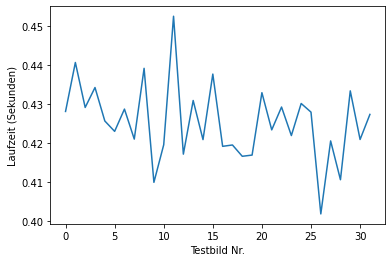

In [17]:
import numpy as np
import matplotlib.pyplot as plt

plt.xlabel("Testbild Nr.")
plt.ylabel("Laufzeit (Sekunden)")
plt.plot(inference_time)
plt.show()

In [11]:
shutil.make_archive('predictions', 'zip', 'predictions')

'/content/predictions.zip'

In [13]:
!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 79
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
stepping	: 0
microcode	: 0x1
cpu MHz		: 2200.206
cache size	: 56320 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm rdseed adx smap xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs taa
bogomips	: 4400.41
clflush size	: 64
cache_alignment	: 64
address sizes	: 46 bits physical, 48 b